In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [3]:
casino = pd.read_csv("Online_casino_DIB.csv")
# Convert the timestamp column to datetime
casino.ReqTimeUTC = pd.to_datetime(casino.ReqTimeUTC)

# Remove timestamps outside the range
casino = casino[casino.ReqTimeUTC <='2020-02-29 00:00:00+00:00'].copy()
# Give new values to df column
casino.TransactionType = casino.TransactionType.map({'LOYALTYCARDDEBIT':'L2D', 'LOYALTYCARDCREDITCL':'L1D', 'LOYALTYCARDCREDIT':'L2W'})
# Filter df by condition 
casino = casino[(casino.TransactionType == "L2D") & (casino.Status=="APPROVED")].reset_index(drop=True)
# and remove single value columns
casino = casino[['AccountIdentifier', 'ReqTimeUTC', 'TransactionAmount']]
# Sort df by column values
casino = casino.sort_values(["AccountIdentifier", "ReqTimeUTC"]).reset_index(drop=True)
# Rename columns
casino.rename(columns = {'AccountIdentifier':'customer', 'ReqTimeUTC':'timest',  'TransactionAmount':'amount'}, inplace=True)
casino.head()

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0


In [4]:
print(len(casino))
print(len(casino.customer.unique()))

69734
2280


In [5]:
#¿Hace cuánto tiempo que la persona es cliente?
#¿Cuándo compró el cliente la última vez?
#¿Cuántas compras tiene el cliente?
base_timestamp = pd.to_datetime("2020-03-01 00:00:00+00:00") #Base de referencia para calcular tiempos.

retention_ = casino.groupby("customer").agg(
    first_active_in_days = ('timest', lambda x: (base_timestamp - x.dt.floor("d").min()).days),  #Días desde la primera actividad del cliente.
    last_active_in_days = ('timest', lambda x: (base_timestamp - x.dt.floor("d").max()).days),   #Días desde la última actividad del cliente.
    nr_purchases = ('timest', 'count')  #Número total de compras realizadas por el cliente.
    )
retention_ = retention_.reset_index()
retention_.head(3)

,customer,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,366,2,444
1,customer10,364,2,1130
2,customer100,267,4,56


In [6]:
#¿Cuánto ha gastado un cliente desde que estuvo activo por primera vez?
#¿Cuán diferentes son las cantidades que gastó el cliente?
overall_spent = casino.groupby("customer").agg({'amount': ['sum', 'std']}).reset_index() #Calcular el gasto total (`sum`) y la desviación estándar (`std`) por cliente.
overall_spent.columns = overall_spent.columns.droplevel(0)
overall_spent.rename(columns={"": "customer"}, inplace=True)
overall_spent.head(3)

,customer,sum,std
0,customer1,34010.0,37.678533
1,customer10,32089.0,13.940103
2,customer100,1639.0,9.195831


In [7]:
# ¿Cuánto gasta el usuario en promedio cada mes?
casino['y_month'] = casino.timest.dt.to_period('M')
monthly_expenditure = casino.groupby(['customer', 'y_month'])['amount'].sum().reset_index()
#Calcular el gasto mensual de cada cliente.
monthly_average_spent = monthly_expenditure.groupby('customer')['amount'].mean().reset_index()
#Calcular el gasto promedio mensual por cliente.
monthly_average_spent.rename(columns={'amount': 'm_avg_spent'}, inplace=True)
monthly_average_spent

/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/2199185909.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  casino['y_month'] = casino.timest.dt.to_period('M')


,customer,m_avg_spent
0,customer1,2834.166667
1,customer10,2674.083333
2,customer100,273.166667
3,customer1000,200.000000
4,customer1001,98.428571
...,...,...
2275,customer995,69.700000
2276,customer996,25.000000
2277,customer997,50.000000
2278,customer998,50.000000


In [8]:
#Unión de métricas en un único DataFrame
overall_spent = overall_spent.set_index("customer")
monthly_average_spent = monthly_average_spent.set_index("customer")
retention_= retention_.set_index("customer")

In [9]:
customer_data = overall_spent.join([monthly_average_spent, retention_]).reset_index()
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.0,37.678533,2834.166667,366,2,444
1,customer10,32089.0,13.940103,2674.083333,364,2,1130
2,customer100,1639.0,9.195831,273.166667,267,4,56
3,customer1000,200.0,0.000000,200.000000,300,300,2
4,customer1001,689.0,13.769130,98.428571,225,21,23
...,...,...,...,...,...,...,...
2275,customer995,348.5,19.800042,69.700000,304,2,6
2276,customer996,50.0,7.637626,25.000000,353,170,3
2277,customer997,50.0,NaN,50.000000,161,161,1
2278,customer998,50.0,0.000000,50.000000,113,113,2


In [10]:
customer_data.isna().sum()
# Fill with 0
customer_data.loc[customer_data["std"].isna(), "std"] = 0.001
customer_data.loc[customer_data["std"] == 0] = 0.001
customer_data

/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/3254858961.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customer_data.loc[customer_data["std"] == 0] = 0.001
/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/3254858961.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  customer_data.loc[customer_data["std"] == 0] = 0.001
/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/3254858961.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001' has dtype incompatible with int64, please explicitly cast to a co

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000
...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001


In [13]:
X = customer_data[['sum', 'std', 'm_avg_spent', 'first_active_in_days','last_active_in_days', 'nr_purchases']]

X_std = np.log(X)
#sns.pairplot(X_std)

[208369.09872861876, 79750.95861767116, 18815.59244941575, 12416.923573367516, 11186.588928345547, 9462.211239675586]


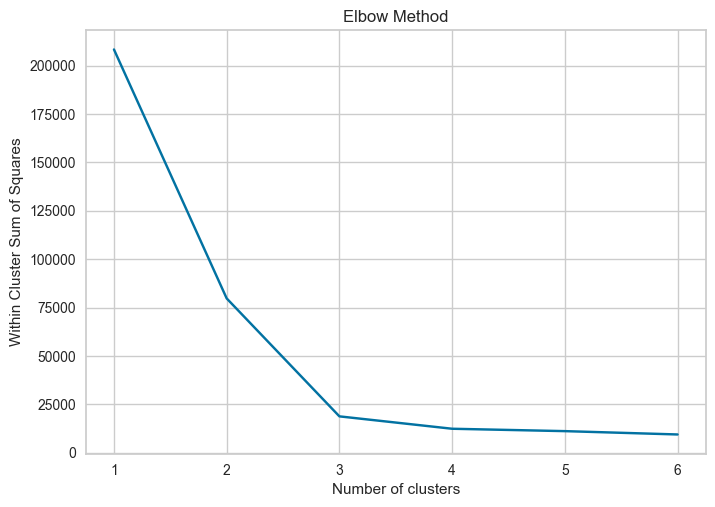

In [14]:
#Análisis de clústeres
cluster = [1,2,3,4,5,6]
wcss_ls = []

for i in cluster:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_std)
    wcss = kmeans.inertia_
    wcss_ls.append(wcss)
print(wcss_ls)
plt.plot(cluster, wcss_ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in [2, 3, 4, 5, 6,7,8,9]:
    '''
    Crea una instancia de KMeans para un número diferente de clústeres
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Crear una instancia de SilhouetteVisualizer con una instancia de KMeans
    Ajustar el visualizador
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_std)
    ax[q-1][mod].set_title(f"{i} clusters")

In [16]:
cluster_model = KMeans(n_clusters=3)
kmeans = cluster_model.fit(X_std)
silhouette_score(X_std, labels = kmeans.labels_)

0.7044985731911864

In [17]:
customer_data['group'] = kmeans.labels_
customer_data

,customer,sum,std,m_avg_spent,first_active_in_days,last_active_in_days,nr_purchases,group
0,customer1,34010.000,37.678533,2834.166667,366.000,2.000,444.000,1
1,customer10,32089.000,13.940103,2674.083333,364.000,2.000,1130.000,1
2,customer100,1639.000,9.195831,273.166667,267.000,4.000,56.000,1
3,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,2
4,customer1001,689.000,13.769130,98.428571,225.000,21.000,23.000,1
...,...,...,...,...,...,...,...,...
2275,customer995,348.500,19.800042,69.700000,304.000,2.000,6.000,1
2276,customer996,50.000,7.637626,25.000000,353.000,170.000,3.000,1
2277,customer997,50.000,0.001000,50.000000,161.000,161.000,1.000,0
2278,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001,2


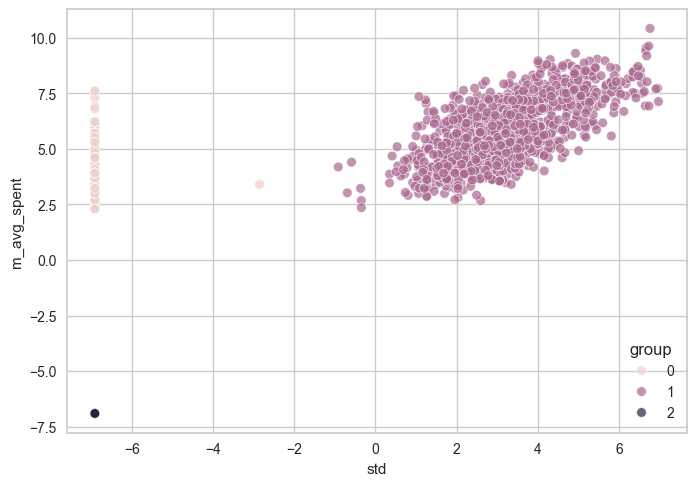

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(X_std, x = "std", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)
plt.show()

[0, 7, 54, 403, 2980, 22026, 162754]
[0, 0.02, 0.14, 1.0, 7.39, 54.6, 403.43]


/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/2862972943.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x)
/var/folders/mv/9jtv_q3s0gs6ndhpn_7nsv900000gq/T/ipykernel_2043/2862972943.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y)


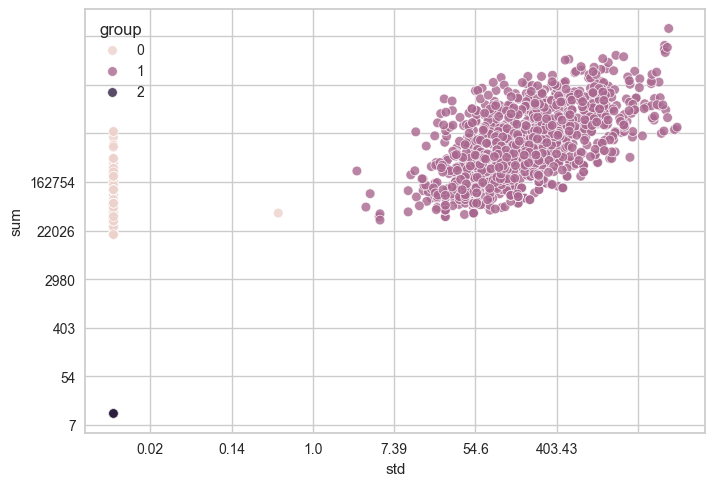

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(X_std, x = "std", y = "sum", hue=customer_data['group'], alpha=0.8)
# sns.scatterplot(X_std, x = "last_active_in_days", y = "m_avg_spent", hue=customer_data['group'], alpha=0.7)

y = [0]
for i in np.arange(2,14,2):
    nr_int = int(np.exp(i))
    y.append(nr_int)
print(y)

x = [0]
for i in range(-4,7,2):
    nr_int = round(np.exp(i),2)
    x.append(nr_int)
print(x)
ax.set_xticklabels(x)
ax.set_yticklabels(y)
plt.show()

In [20]:
customer_data.to_csv('customer_data.csv', index=False)